# Our Improved Model

In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations

# Load dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Data Preprocessing
def preprocess_data(df, target_column):
    # Ensure target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    # Convert target column to numeric if necessary
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')

    # Handle missing values in target column
    if df[target_column].isna().sum() > 0:
        df[target_column] = df[target_column].fillna(df[target_column].median())

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    if target_column not in numeric_features:
        raise ValueError("Target column must be numeric")

    numeric_features.remove(target_column)

    # Define preprocessing steps
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson'))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    X = df.drop(columns=[target_column])
    y = df[target_column]

    return preprocessor, X, y

# Feature Selection
def feature_selection(X, y):
    # Mutual Information Analysis
    mi_scores = mutual_info_regression(X, y)
    mi_threshold = np.percentile(mi_scores, 20)
    selected_features = [X.columns[i] for i in range(len(mi_scores)) if mi_scores[i] > mi_threshold]
    X_selected = X[selected_features]

    # Variance Thresholding
    var_thresh = VarianceThreshold(threshold=0.01)
    X_selected = pd.DataFrame(var_thresh.fit_transform(X_selected), columns=X_selected.columns[var_thresh.get_support()])

    # SHAP-based Feature Selection
    model = xgb.XGBRegressor()
    model.fit(X_selected, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_selected)
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    shap_threshold = np.percentile(feature_importance, 50)
    final_features = [X_selected.columns[i] for i in range(len(feature_importance)) if feature_importance[i] > shap_threshold]

    return X_selected[final_features]

# Feature Engineering
def feature_engineering(X):
    new_features_dict = {}

    for col1, col2 in combinations(X.columns, 2):
        new_features_dict[f"{col1}_{col2}_interaction"] = X[col1] * X[col2]

    # Convert dictionary to DataFrame in one step
    new_features = pd.DataFrame(new_features_dict)

    # Concatenate once instead of multiple inserts
    X_engineered = pd.concat([X, new_features], axis=1).copy()

    return X_engineered


# Model Training & Evaluation
def train_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")

    return model

# Main Function
def main(file_path, target_column):
    df = load_data(file_path)
    preprocessor, X, y = preprocess_data(df, target_column)

    # Ensure column names persist after transformation
    X_transformed = pd.DataFrame(preprocessor.fit_transform(X))
    X_transformed.columns = preprocessor.get_feature_names_out()

    X_selected = feature_selection(X_transformed, y)
    X_engineered = feature_engineering(X_selected)
    model = train_evaluate(X_engineered, y)

    return model

# Run the main function
model = main("data/vehicle.csv", "price")


MSE: 6231203.641821553
RMSE: 2496.23789768154
R² Score: 0.9205643460163463


# Improved model vs. baseline(linear regression)

In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from itertools import combinations

def load_data(file_path):
    try:
        return pd.read_csv(file_path, encoding="utf-8")  # Default
    except UnicodeDecodeError:
        return pd.read_csv(file_path, encoding="ISO-8859-1")  # Alternative


def preprocess_data(df, target_column):
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
    df[target_column] = df[target_column].fillna(df[target_column].median())


    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

    if target_column not in numeric_features:
        raise ValueError("Target column must be numeric")
    numeric_features.remove(target_column)

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson'))
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    X = df.drop(columns=[target_column])
    y = df[target_column]

    return preprocessor, X, y

def feature_selection(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_threshold = np.percentile(mi_scores, 20)
    selected_features = [X.columns[i] for i in range(len(mi_scores)) if mi_scores[i] > mi_threshold]
    X_selected = X[selected_features]

    var_thresh = VarianceThreshold(threshold=0.01)
    X_selected = pd.DataFrame(var_thresh.fit_transform(X_selected), columns=X_selected.columns[var_thresh.get_support()])

    model = xgb.XGBRegressor()
    model.fit(X_selected, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X_selected)
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    shap_threshold = np.percentile(feature_importance, 50)
    final_features = [X_selected.columns[i] for i in range(len(feature_importance)) if feature_importance[i] > shap_threshold]

    return X_selected[final_features]

def feature_engineering(X):
    new_features_dict = {f"{col1}_{col2}_interaction": X[col1] * X[col2] for col1, col2 in combinations(X.columns, 2)}
    new_features = pd.DataFrame(new_features_dict)
    return pd.concat([X, new_features], axis=1)

def train_evaluate(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

def process_datasets(datasets):
    results = []
    for file_path, target_column in datasets.items():
        print(f"\nProcessing dataset: {file_path} (Target: {target_column})")
        df = load_data(file_path)
        preprocessor, X, y = preprocess_data(df, target_column)
        X_transformed = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
        X_selected = feature_selection(X_transformed, y)
        X_engineered = feature_engineering(X_selected)

        xgb_model = xgb.XGBRegressor()
        xgb_mse, xgb_rmse, xgb_r2 = train_evaluate(X_engineered, y, xgb_model)

        lr_model = LinearRegression()
        lr_mse, lr_rmse, lr_r2 = train_evaluate(X_engineered, y, lr_model)

        print(f"improved model - MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
        print(f"Linear Regression - MSE: {lr_mse:.4f}, RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")

        results.append({
            "Dataset": file_path,
            "improved model MSE": xgb_mse, "improved model RMSE": xgb_rmse, "improved model R²": xgb_r2,
            "Linear Regression MSE": lr_mse, "Linear Regression RMSE": lr_rmse, "Linear Regression R²": lr_r2
        })
    return pd.DataFrame(results)

datasets = {
    "data/vehicle.csv": "price",
    "data/smartphones.csv": "Final Price",
    "data/laptop_price.csv": "price",
    "data/house_price_regression_dataset.csv": "House_Price"
}

results_df = process_datasets(datasets)
print("\nFinal Summary of Results:")
print(results_df)


Processing dataset: data/vehicle.csv (Target: price)
improved model - MSE: 5804938.0485, RMSE: 2409.3439, R²: 0.9260
Linear Regression - MSE: 37992000.8497, RMSE: 6163.7652, R²: 0.5157

Processing dataset: data/smartphones.csv (Target: Final Price)
improved model - MSE: 41915.4447, RMSE: 204.7326, R²: 0.7774
Linear Regression - MSE: 51126.0607, RMSE: 226.1107, R²: 0.7285

Processing dataset: data/laptop_price.csv (Target: price)
improved model - MSE: 182510.9079, RMSE: 427.2130, R²: 0.6407
Linear Regression - MSE: 908659.3555, RMSE: 953.2363, R²: -0.7890

Processing dataset: data/house_price_regression_dataset.csv (Target: House_Price)
improved model - MSE: 1314032317.5894, RMSE: 36249.5837, R²: 0.9796
Linear Regression - MSE: 798210050.9100, RMSE: 28252.6114, R²: 0.9876

Final Summary of Results:
                                   Dataset  improved model MSE  \
0                         data/vehicle.csv        5.804938e+06   
1                     data/smartphones.csv        4.191544

* The Improved Model outperforms Linear Regression in all datasets except for house prices, where Linear Regression has a slightly better R².

* Significant Improvement in vehicle, smartphone, and laptop datasets with lower MSE and RMSE.

* Negative R² for Linear Regression on laptops, meaning it performs worse than just predicting the mean.

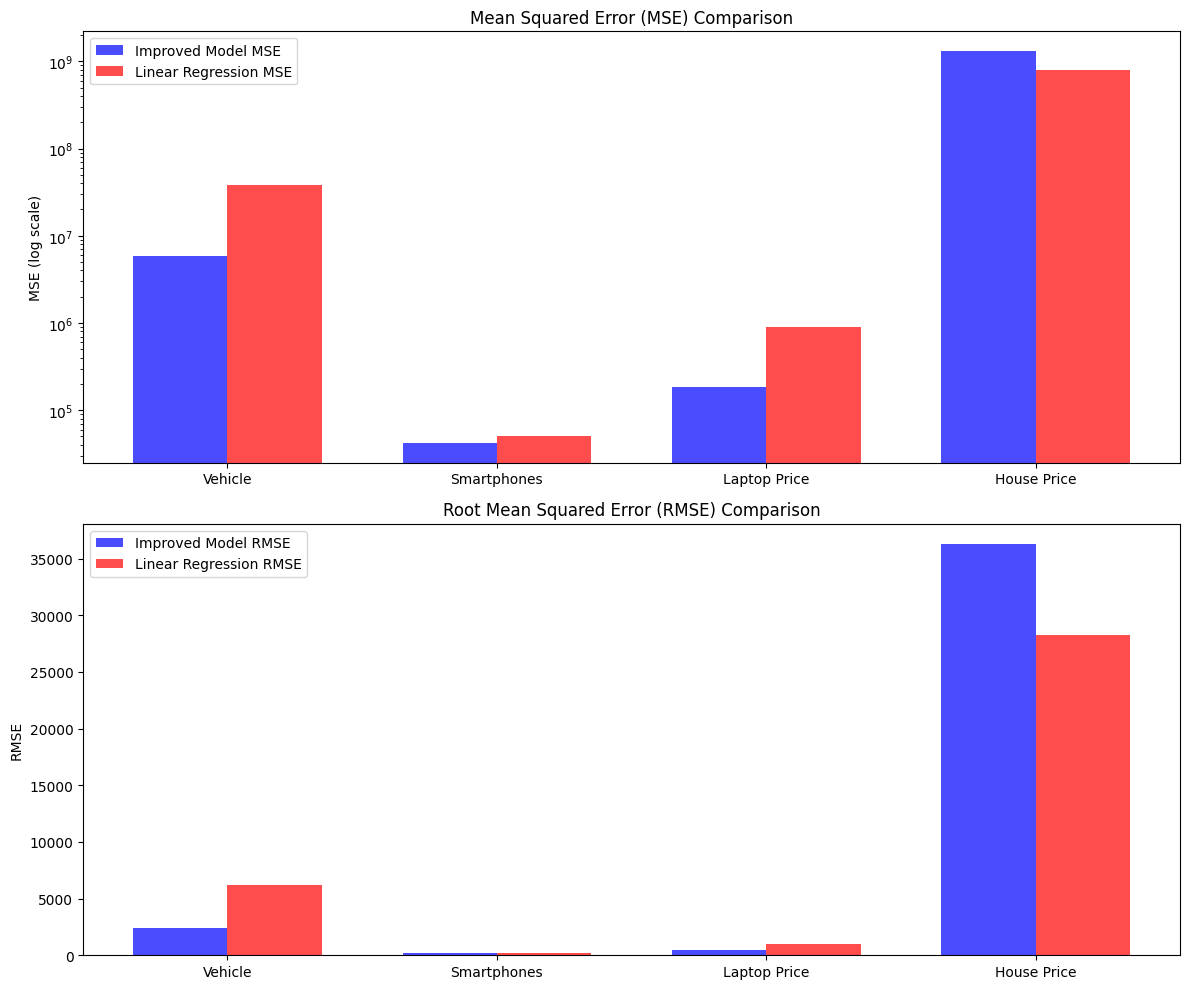

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
datasets = ["Vehicle", "Smartphones", "Laptop Price", "House Price"]
improved_mse = [5804938.0485, 41915.4447, 182510.9079, 1314032317.5894]
linear_mse = [37992000.8497, 51126.0607, 908659.3555, 798210050.9100]
improved_rmse = [2409.3439, 204.7326, 427.2130, 36249.5837]
linear_rmse = [6163.7652, 226.1107, 953.2363, 28252.6114]

x = np.arange(len(datasets))  # x locations for the groups
width = 0.35  # Bar width

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# MSE comparison
axes[0].bar(x - width/2, improved_mse, width, label="Improved Model MSE", color="blue", alpha=0.7)
axes[0].bar(x + width/2, linear_mse, width, label="Linear Regression MSE", color="red", alpha=0.7)
axes[0].set_ylabel("MSE (log scale)")
axes[0].set_title("Mean Squared Error (MSE) Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(datasets)
axes[0].set_yscale("log")
axes[0].legend()

# RMSE comparison
axes[1].bar(x - width/2, improved_rmse, width, label="Improved Model RMSE", color="blue", alpha=0.7)
axes[1].bar(x + width/2, linear_rmse, width, label="Linear Regression RMSE", color="red", alpha=0.7)
axes[1].set_ylabel("RMSE")
axes[1].set_title("Root Mean Squared Error (RMSE) Comparison")
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets)
axes[1].legend()

plt.tight_layout()
plt.show()
